Load and Explore the Dataset
Preprocess the Data
Tokenize the URLs using BERT tokenizer
Prepare the Data for the BERT Model
Build and Train the BERT Model
Evaluate the Model
Visualize the Results

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Step 1: Load and Explore the Dataset
import pandas as pd
import torch

# Load the dataset

file_path = '/content/drive/My Drive/DoAn/data.csv'
data = pd.read_csv(file_path)


# Display the first few rows of the dataset
data.head()

,rec_id,url,website,result,created_date
0,1.0,http://intego3.info/EXEL/index.php,1613573972338075.html,1,2/17/2021 20:29
1,16.0,https://easc.do/abc/pre_qualify.php,16249662296873.html,1,6/29/2021 11:30
2,19.0,https://www.tontonfree-getxx8.duckdns.org/,1624422656324031.html,1,6/23/2021 4:30
3,22.0,http://mrsbt213.yolasite.com/,1607095600394378.html,1,12/4/2020 20:56
4,23.0,http://234.50.198.35.bc.googleusercontent.com/...,1620759901211522.html,1,5/12/2021 0:35


In [ ]:
# Step 2: Preprocess the Data
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader

# Split the data into training and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# Custom dataset class
class URLDataset(Dataset):
    def __init__(self, urls, labels, tokenizer, max_length=128):
        self.urls = urls
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.urls)

    def __getitem__(self, idx):
        url = self.urls.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer.encode_plus(
            url,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return encoding['input_ids'].squeeze(0), encoding['attention_mask'].squeeze(0), torch.tensor(label, dtype=torch.long)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Step 3: Prepare the Data for the BERT Model

# from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#

# Create datasets
train_dataset = URLDataset(train_data['url'], train_data['result'], tokenizer)
test_dataset = URLDataset(test_data['url'], test_data['result'], tokenizer)

# # Create data loaders
# batch_size = 32
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# thử
import pandas as pd

# Tokenize and save to CSV
def tokenize_and_save_to_csv(data, tokenizer, max_length, file_path):
    input_ids_list = []
    attention_mask_list = []
    labels_list = []

    for index, row in data.iterrows():
        url = row['url']
        label = row['result']

        encoding = tokenizer.encode_plus(
            url,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids_list.append(encoding['input_ids'].squeeze(0).tolist())
        attention_mask_list.append(encoding['attention_mask'].squeeze(0).tolist())
        labels_list.append(label)

    # Save to CSV
    tokenized_data = pd.DataFrame({
        'input_ids': input_ids_list,
        'attention_mask': attention_mask_list,
        'label': labels_list
    })
    tokenized_data.to_csv(file_path, index=False)
    print(f"Tokenized data saved to {file_path}")

# Example usage for saving train and test data
tokenize_and_save_to_csv(train_data, tokenizer, max_length=128, file_path="/content/drive/My Drive/DoAn/train_tokenized.csv")
tokenize_and_save_to_csv(test_data, tokenizer, max_length=128, file_path="/content/drive/My Drive/DoAn/test_tokenized.csv")



Tokenized data saved to /content/drive/My Drive/DoAn/train_tokenized.csv
Tokenized data saved to /content/drive/My Drive/DoAn/test_tokenized.csv


In [ ]:
#thử
# Custom Dataset class for loading from tokenized CSV file
class TokenizedURLDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_ids = torch.tensor(eval(self.data.iloc[idx]['input_ids']), dtype=torch.long)
        attention_mask = torch.tensor(eval(self.data.iloc[idx]['attention_mask']), dtype=torch.long)
        label = torch.tensor(self.data.iloc[idx]['label'], dtype=torch.long)

        return input_ids, attention_mask, label

# Load tokenized data from CSV
train_dataset = TokenizedURLDataset("/content/drive/My Drive/DoAn/train_tokenized.csv")
test_dataset = TokenizedURLDataset("/content/drive/My Drive/DoAn/test_tokenized.csv")

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
Training loss: 0.13208768848426544, Training accuracy: 0.9488961038961039
Validation loss: 0.07315217351629805, Validation accuracy: 0.972899377593361
New best model saved with accuracy: 0.972899377593361
Epoch 2/3
Training loss: 0.052774982230855735, Training accuracy: 0.9810064935064935
Validation loss: 0.0636019706765926, Validation accuracy: 0.9782157676348547
New best model saved with accuracy: 0.9782157676348547
Epoch 3/3
Training loss: 0.021153652736699426, Training accuracy: 0.9931818181818182
Validation loss: 0.07160350344198997, Validation accuracy: 0.9783454356846473
New best model saved with accuracy: 0.9783454356846473


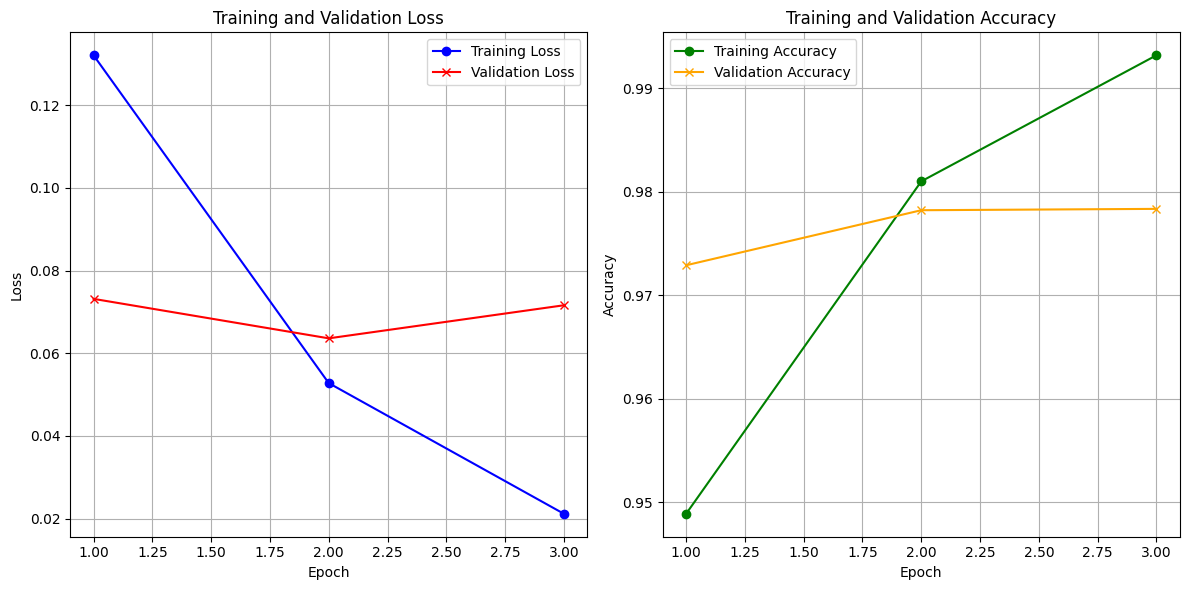

In [ ]:
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss

# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).cuda()

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Set up the training loop
epochs = 3
total_steps = len(train_loader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Set up the loss function
loss_fn = CrossEntropyLoss()

# Function to calculate accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Track the best validation accuracy
best_accuracy = 0.0

# Lists to track loss and accuracy for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Training
    model.train()
    total_loss = 0
    total_accuracy = 0
    nb_train_steps = 0
    for step, batch in enumerate(train_loader):
        batch_input_ids, batch_attention_mask, batch_labels = batch
        batch_input_ids = batch_input_ids.cuda()
        batch_attention_mask = batch_attention_mask.cuda()
        batch_labels = batch_labels.cuda()

        model.zero_grad()

        outputs = model(batch_input_ids, attention_mask=batch_attention_mask, labels=batch_labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()

        # Calculate training accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = batch_labels.to('cpu').numpy()
        total_accuracy += flat_accuracy(logits, label_ids)
        nb_train_steps += 1

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_loader)
    avg_train_accuracy = total_accuracy / nb_train_steps
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)
    print(f"Training loss: {avg_train_loss}, Training accuracy: {avg_train_accuracy}")

    # Evaluation
    model.eval()
    eval_loss = 0
    eval_accuracy = 0
    nb_eval_steps = 0

    for batch in test_loader:
        batch_input_ids, batch_attention_mask, batch_labels = batch

        batch_input_ids = batch_input_ids.cuda()
        batch_attention_mask = batch_attention_mask.cuda()
        batch_labels = batch_labels.cuda()

        with torch.no_grad():
            outputs = model(batch_input_ids, attention_mask=batch_attention_mask, labels=batch_labels)

        loss = outputs.loss
        logits = outputs.logits

        eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = batch_labels.to('cpu').numpy()

        eval_accuracy += flat_accuracy(logits, label_ids)
        nb_eval_steps += 1

    avg_eval_loss = eval_loss / len(test_loader)
    avg_eval_accuracy = eval_accuracy / nb_eval_steps
    val_losses.append(avg_eval_loss)
    val_accuracies.append(avg_eval_accuracy)
    print(f"Validation loss: {avg_eval_loss}, Validation accuracy: {avg_eval_accuracy}")

    # Save the model if the validation accuracy is the best so far
    if avg_eval_accuracy > best_accuracy:
        best_accuracy = avg_eval_accuracy
        model.save_pretrained('/content/drive/My Drive/DoAn/best_model_.pt')
        print(f"New best model saved with accuracy: {best_accuracy}")

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='red', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', color='green', marker='o')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', color='orange', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Test set accuracy: 0.9783018255050997
Class 0:
  Precision: 0.975800156128025
  Recall: 0.9806485355648535
  F1 Score: 0.978218338333116
Class 1:
  Precision: 0.9807966783443622
  Recall: 0.975984506132989
  F1 Score: 0.9783846751229613


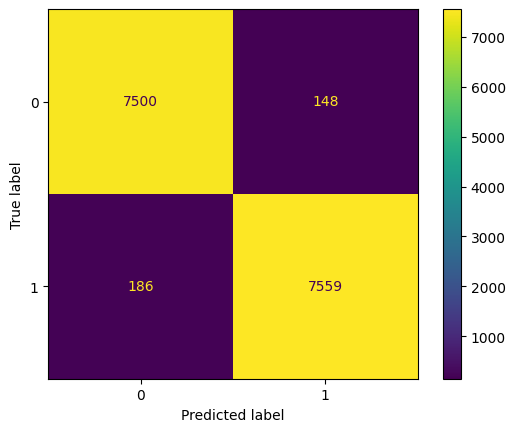

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Function to evaluate the model and get predictions
def evaluate_model(dataloader):
    model.eval()
    predictions, true_labels = [], []

    for batch in dataloader:
        batch_input_ids, batch_attention_mask, batch_labels = batch

        batch_input_ids = batch_input_ids.cuda()
        batch_attention_mask = batch_attention_mask.cuda()
        batch_labels = batch_labels.cuda()

        with torch.no_grad():
            outputs = model(batch_input_ids, attention_mask=batch_attention_mask)

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = batch_labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

    return predictions, true_labels

# Function to calculate flat accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, pred_flat)

# Evaluate on the test set
predictions, true_labels = evaluate_model(test_loader)

# Flatten the predictions and true labels
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Calculate accuracy
accuracy = flat_accuracy(predictions, true_labels)
print(f"Test set accuracy: {accuracy}")

# Get the predicted labels
pred_labels = np.argmax(predictions, axis=1)

# Compute precision, recall, and F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average=None)

# Print precision, recall, and F1-score for each class
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f"Class {i}:")
    print(f"  Precision: {p}")
    print(f"  Recall: {r}")
    print(f"  F1 Score: {f}")

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader

# Đọc dữ liệu từ remaining_data.csv
remaining_data_path = '/content/drive/My Drive/DoAn/test.csv'  # Thay đổi đường dẫn đến tệp của bạn
remaining_data = pd.read_csv(remaining_data_path)

# Kiểm tra dữ liệu
print(remaining_data.head())

# Tạo tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tạo URL dataset cho dữ liệu còn lại
remaining_dataset = URLDataset(remaining_data['url'], remaining_data['result'], tokenizer)

# Tạo DataLoader cho dữ liệu còn lại
batch_size = 32
remaining_loader = DataLoader(remaining_dataset, batch_size=batch_size, shuffle=False)


    rec_id                                         url                website  \
0      NaN     https://gratis-5483547.webadorsite.com/         page_1686.html   
1  25386.0      http://www.6awvigr.cn/2nhuJi43/dbs-wa/          10000882.html   
2      NaN                     https://l.ead.me/bfKJ0g        page_15127.html   
3      NaN  https://help-content-coinbse.gitbook.io/us         page_1441.html   
4  16260.0            https://barclaycard.signln.link/  1613573731481908.html   

   result      created_date  
0       1               NaN  
1       1  10/31/2021 22:55  
2       1               NaN  
3       1               NaN  
4       1   2/17/2021 20:25  


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Tải mô hình đã huấn luyện từ file 'best_model.pt'
model = BertForSequenceClassification.from_pretrained('/content/drive/My Drive/DoAn/best_model_.pt')
model.cuda()
model.eval()  # Chuyển mô hình sang chế độ đánh giá

# Hàm để dự đoán và tính toán các chỉ số đánh giá
def predict_and_evaluate(dataloader):
    predictions, true_labels = [], []

    for batch in dataloader:
        batch_input_ids, batch_attention_mask, batch_labels = batch

        # Chuyển dữ liệu lên GPU nếu có
        batch_input_ids = batch_input_ids.cuda()
        batch_attention_mask = batch_attention_mask.cuda()
        batch_labels = batch_labels.cuda()

        with torch.no_grad():
            outputs = model(batch_input_ids, attention_mask=batch_attention_mask)

        # Lấy kết quả dự đoán
        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = batch_labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

    return predictions, true_labels


Test set accuracy: 0.976140350877193
Class 0:
  Precision: 0.9739231664726427
  Recall: 0.9784795321637427
  F1 Score: 0.9761960326721121
Class 1:
  Precision: 0.9783783783783784
  Recall: 0.9738011695906432
  F1 Score: 0.976084407971864


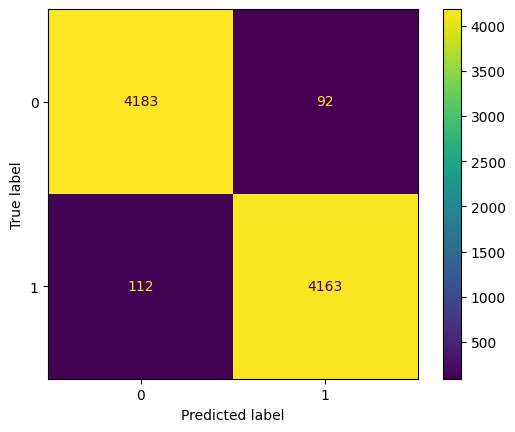

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Gọi hàm dự đoán
predictions, true_labels = predict_and_evaluate(remaining_loader)

# Chuyển đổi các kết quả thành các mảng numpy
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Tính toán độ chính xác
accuracy = flat_accuracy(predictions, true_labels)
print(f"Test set accuracy: {accuracy}")

# Lấy nhãn dự đoán
pred_labels = np.argmax(predictions, axis=1)

# Tính toán precision, recall, và F1-score cho mỗi lớp
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average=None)

# In kết quả
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f"Class {i}:")
    print(f"  Precision: {p}")
    print(f"  Recall: {r}")
    print(f"  F1 Score: {f}")

# Tính toán và hiển thị ma trận nhầm lẫn
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.7 MB/s eta 0:00:00


In [ ]:
import os
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import urllib.parse
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import re
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')

PATH = '/content/drive/My Drive/DoAn/data_/data'


def count_hyperlinks(html_content):
    try:
        html_content = os.path.join(PATH, html_content)
        # Parse HTML using BeautifulSoup
        soup = BeautifulSoup(html_content, 'html.parser')

        # Count the number of hyperlinks (href, link, and src tags)
        total_hyperlinks = len(soup.find_all(['a', 'link', 'img']))

        # Determine if the website is legitimate or phishing based on the hyperlink count
        return 1 if total_hyperlinks == 0 else 0

    except Exception as e:
        print(f"Error: {e}")
        return 0  # Error occurred


def calculate_internal_link_ratio(html_content, base_domain):
    try:
        # html_content = os.path.join(PATH, html_content)
        # html_content = open(html_content, 'r', encoding='utf-8').read()

        html_content = open(PATH + '/' + html_content, 'r', encoding='utf-8').read()
        soup = BeautifulSoup(html_content, 'html.parser')

        total_links = 0
        internal_links = 0

        for a_tag in soup.find_all('a', href=True):
            total_links += 1
            href = a_tag['href']
            parsed_href = urllib.parse.urlparse(href)

            if not parsed_href.netloc:  # Relative link
                internal_links += 1
            elif parsed_href.netloc == base_domain:  # Internal link
                internal_links += 1

        if total_links == 0:
            return 1  # Avoid division by zero

        internal_link_ratio = internal_links / total_links

        if internal_link_ratio >= 0.5:
            return 0
        else:
            return 1

    except Exception as e:
        print(f"Error: {e}")
        return 0  # Error occurred


def calculate_external_link_ratio(html_content, base_domain):
    try:
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        # html_content = os.path.join(PATH, html_content)
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        html_content = open(PATH + '/' + html_content, 'r', encoding='utf-8').read()
        soup = BeautifulSoup(html_content, 'html.parser')

        total_links = 0
        external_links = 0

        for a_tag in soup.find_all('a', href=True):
            total_links += 1
            href = a_tag['href']
            parsed_href = urllib.parse.urlparse(href)

            if parsed_href.netloc and parsed_href.netloc != base_domain:  # External link
                external_links += 1

        if total_links == 0:
            return 1  # Avoid division by zero

        external_link_ratio = external_links / total_links

        if external_link_ratio < 0.5:
            return 0
        else:
            return 1

    except Exception as e:
        print(f"Error: {e}")
        return 0


def has_external_css(html_content, base_domain):
    try:
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        # html_content = os.path.join(PATH, html_content)
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        html_content = open(PATH + '/' + html_content, 'r', encoding='utf-8').read()
        soup = BeautifulSoup(html_content, 'html.parser')

        for link_tag in soup.find_all('link', rel='stylesheet', href=True):
            href = link_tag['href']
            parsed_href = urllib.parse.urlparse(href)

            if parsed_href.netloc and parsed_href.netloc != base_domain:
                return 1  # External CSS found with a foreign domain

        return 0  # No external CSS with a foreign domain found

    except Exception as e:
        print(f"Error: {e}")
        return 0


def is_suspicious_form_action(html_content, base_domain):
    try:
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        # html_content = os.path.join(PATH, html_content)
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        html_content = open(PATH + '/' + html_content, 'r', encoding='utf-8').read()
        soup = BeautifulSoup(html_content, 'html.parser')

        for form_tag in soup.find_all('form', action=True):
            action = form_tag['action']
            parsed_action = urllib.parse.urlparse(action)

            if parsed_action.netloc and parsed_action.netloc != base_domain:
                return 1  # Suspicious form action with external link or PHP file

            # Additional checks for common suspicious values
            if action.lower() in {'null', '#', 'javascript:void()', 'javascript:void(0)'}:
                return 1  # Suspicious form action with null or JavaScript value

        return 0  # No suspicious form action found

    except Exception as e:
        print(f"Error: {e}")
        return 0

def detect_null_links(html_content):
    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find all anchor tags in the HTML content
    anchors = soup.find_all('a')

    if not anchors:  # If no anchors found, return 0 (no null links)
        return 0

    # Count the number of null links (href contains '#', '#content', 'javascript:void(0)')
    null_links = 0
    total_anchors = len(anchors)

    for anchor in anchors:
        href = anchor.get('href', '')
        if href in ['#', '#content', 'javascript:void(0)']:
            null_links += 1

    # Calculate the ratio of null links
    null_link_ratio = null_links / total_anchors

    # If the ratio of null links is greater than 0.34, return 1 (phishing), else return 0 (legitimate)
    return 1 if null_link_ratio > 0.34 else 0

def is_external_favicon(html_content, base_domain):
    try:
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        # html_content = os.path.join(PATH, html_content)
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        html_content = open(PATH + '/' + html_content, 'r', encoding='utf-8').read()
        soup = BeautifulSoup(html_content, 'html.parser')

        for link_tag in soup.find_all('link', rel='icon', href=True):
            href = link_tag['href']
            parsed_href = urllib.parse.urlparse(href)

            if parsed_href.netloc and parsed_href.netloc != base_domain:
                return 1  # External favicon found with a foreign domain

        return 0  # No external favicon with a foreign domain found

    except Exception as e:
        print(f"Error: {e}")
        return 0


def calculate_common_page_detection_ratio(html_content):
    try:
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        # html_content = os.path.join(PATH, html_content)
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        html_content = open(PATH + '/' + html_content, 'r', encoding='utf-8').read()
        soup = BeautifulSoup(html_content, 'html.parser')

        anchor_links = [a_tag['href'] for a_tag in soup.find_all('a', href=True)]
        if not anchor_links:
            return 0  # No anchor links found

        most_common_link = max(set(anchor_links), key=anchor_links.count)
        common_link_frequency = anchor_links.count(most_common_link)

        common_page_detection_ratio = common_link_frequency / len(anchor_links)
        return common_page_detection_ratio

    except Exception as e:
        print(f"Error: {e}")
        return 0


def calculate_common_page_in_footer_ratio(html_content):
    try:
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        # html_content = os.path.join(PATH, html_content)
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        html_content = open(PATH + '/' + html_content, 'r', encoding='utf-8').read()
        soup = BeautifulSoup(html_content, 'html.parser')

        # Extract anchor links within the footer section
        footer_anchor_links = [a_tag['href'] for footer_tag in soup.find_all('footer') for a_tag in
                               footer_tag.find_all('a', href=True)]

        if not footer_anchor_links:
            return 0  # No anchor links found in the footer section

        most_common_link = max(set(footer_anchor_links), key=footer_anchor_links.count)
        common_link_frequency = footer_anchor_links.count(most_common_link)

        common_page_in_footer_ratio = common_link_frequency / len(footer_anchor_links)
        return common_page_in_footer_ratio

    except Exception as e:
        print(f"Error: {e}")
        return None


def check_sfh(html_content, base_domain):
    try:
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        # html_content = os.path.join(PATH, html_content)
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        html_content = open(PATH + '/' + html_content, 'r', encoding='utf-8').read()
        soup = BeautifulSoup(html_content, 'html.parser')

        for form_tag in soup.find_all('form', action=True):
            sfh = form_tag['action']

            # Check for empty or 'about:blank' SFH
            if sfh.lower() in {'', 'about:blank'}:
                return 0.5  # SFH is empty or 'about:blank'

            # Check if SFH domain is external
            parsed_sfh = urllib.parse.urlparse(sfh)
            if parsed_sfh.netloc and parsed_sfh.netloc != base_domain:
                return 1  # SFH domain is external

        return 0  # Legitimate SFH

    except Exception as e:
        print(f"Error: {e}")
        return 0

def has_www(url):
    pattern = re.compile(r'^www\.')
    match = re.search(pattern, url)
    return 1 if bool(match) else 0


def count_subdomains(url):
    # Check if the URL starts with "http://" or "https://"
    if url.startswith("http://"):
        url = url[7:]
    elif url.startswith("https://"):
        url = url[8:]

    # Split the URL by dots
    parts = url.split('.')

    # Count the number of parts
    part_count = len(parts)

    # Classify the URL based on the specified criteria
    if part_count == 2:
        feature_value = 0.0
    elif part_count == 3:
        feature_value = 0.5
    else:
        feature_value = 1.0

    return feature_value


def check_ip_in_domain(url):
    # Extract the domain from the URL using a regular expression
    domain_match = re.search(r'https?://([^/]+)', url)

    if domain_match:
        domain = domain_match.group(1)

        # Check if the domain is an IP address
        if re.match(r'^\d+\.\d+\.\d+\.\d+$', domain) or re.match(r'^[0-9a-fA-F:]+$', domain):
            feature_value = 1.0
        else:
            feature_value = 0.0
    else:
        feature_value = 0.0

    return feature_value


def check_at_symbol(url):
    # Check if the "@" symbol is present in the URL
    if "@" in url:
        feature_value = 1.0
    else:
        feature_value = 0.0

    return feature_value


def check_url_length(url):
    # Check the length of the URL
    url_length = len(url)

    # Classify the URL based on the specified criteria
    if 75 < url_length < 100:
        feature_value = 0.5
    elif url_length >= 100:
        feature_value = 1.0
    else:
        feature_value = 0.0

    return feature_value


def calculate_url_depth(url):
    # Split the URL path by "/"
    path_segments = url.split("/")[3:]  # Exclude the protocol (http/https) and domain

    # Calculate the depth based on the number of subpages
    url_depth = len(path_segments)

    # Return the numerical feature value
    return url_depth


def check_double_slash(url):
    # Find the last occurrence of "//" in the URL
    last_double_slash = url.rfind("//")

    # Classify the URL based on the specified criteria
    if last_double_slash > 7:
        feature_value = 1.0
    else:
        feature_value = 0.0

    return feature_value


def check_http_in_domain(url):
    # Extract the domain from the URL
    domain_start = url.find('//') + 2
    domain_end = url.find('/', domain_start)

    if domain_end == -1:
        domain_end = None

    domain = url[domain_start:domain_end]

    # Check if "http" or "https" is present in the domain
    if "http" in domain:
        feature_value = 1.0
    else:
        feature_value = 0.0

    return feature_value


def check_https_protocol(url):
    # Check if the URL has the "https" protocol
    if url.startswith('https://'):
        feature_value = 0.0
    else:
        feature_value = 1.0

    return feature_value


def check_url_shortening(url):
    # List of common URL shortening services
    shortening_services = ['bit.ly', 'goo.gl', 'tinyurl.com', 'ow.ly', 't.co']

    # Check if the URL contains any of the shortening service domains
    if any(service in url for service in shortening_services):
        feature_value = 1.0
    else:
        feature_value = 0.0

    return feature_value


def check_dash_in_domain(url):
    # Extract the domain from the URL
    domain_start = url.find('//') + 2
    domain_end = url.find('/', domain_start)

    if domain_end == -1:
        domain_end = None

    domain = url[domain_start:domain_end]

    # Check if "-" is present in the domain
    if '-' in domain:
        feature_value = 1.0
    else:
        feature_value = 0.0

    return feature_value


def check_sensitive_words(url):
    # List of sensitive words/phishing terms
    phishing_terms = ['login', 'update', 'validate', 'activate', 'secure', 'account', 'verification', 'password',
                      'confirm', 'verification', 'signin', 'recover', 'auth', 'identity', 'info', 'alert', 'warning',
                      'urgent']

    # Convert the URL to lowercase for case-insensitive matching
    url_lower = url.lower()

    # Check if the URL contains any of the phishing terms
    if any(term in url_lower for term in phishing_terms):
        feature_value = 1.0
    else:
        feature_value = 0.0

    return feature_value


def check_trendy_brand_name(url):
    # List of trendy brand names that phishers often target
    trendy_brands = ['apple', 'google', 'microsoft', 'amazon', 'facebook', 'paypal', 'netflix', 'instagram', 'twitter',
                     'linkedin', 'ebay', 'yahoo', 'dropbox', 'adobe', 'linkedin', 'outlook', 'snapchat', 'uber',
                     'whatsapp']

    # Convert the URL to lowercase for case-insensitive matching
    url_lower = url.lower()

    # Check if the URL contains any of the trendy brand names
    if any(brand in url_lower for brand in trendy_brands):
        feature_value = 1.0
    else:
        feature_value = 0.0

    return feature_value


def check_uppercase_letters(url):
    # Check if the URL contains any uppercase letters
    if any(char.isupper() for char in url):
        feature_value = 1.0
    else:
        feature_value = 0.0

    return feature_value


def count_dots(url):
    # Count the number of dots in the URL
    dot_count = url.count('.')

    # Check if the number of dots is more than 2
    if dot_count > 2:
        feature_value = 1.0
    else:
        feature_value = 0.0

    return feature_value


df = pd.read_csv("/content/drive/My Drive/DoAn/data.csv", on_bad_lines='skip', encoding="latin-1")


df['UF1'] = df['website'].apply(lambda x: count_hyperlinks(x))

df['UF1'] = df['website'].apply(lambda x: count_hyperlinks(x))
df['UF2'] = df.apply(
    lambda row: calculate_internal_link_ratio(row['website'], urllib.parse.urlparse(row['url']).netloc), axis=1)

df['UF3'] = df.apply(
    lambda row: calculate_external_link_ratio(row['website'], urllib.parse.urlparse(row['url']).netloc), axis=1)
df['UF4'] = df.apply(lambda row: has_external_css(row['website'], urllib.parse.urlparse(row['url']).netloc), axis=1)
df['UF5'] = df.apply(lambda row: is_suspicious_form_action(row['website'], urllib.parse.urlparse(row['url']).netloc),
                     axis=1)
df['UF6'] = df.apply(lambda row: detect_null_links(row['website']), axis=1)
df['UF7'] = df.apply(lambda row: is_external_favicon(row['website'], urllib.parse.urlparse(row['url']).netloc), axis=1)
df['UF8'] = df.apply(lambda row: calculate_common_page_detection_ratio(row['website']), axis=1)
df['UF9'] = df.apply(lambda row: calculate_common_page_in_footer_ratio(row['website']), axis=1)
df['UF10'] = df.apply(lambda row: check_sfh(row['website'], urllib.parse.urlparse(row['url']).netloc), axis=1)
df['UF11'] = df.apply(lambda row: has_www(row['url']), axis=1)
df['UF12'] = df.apply(lambda row: count_subdomains(row['url']), axis=1)
df['UF13'] = df.apply(lambda row: check_ip_in_domain(row['url']), axis=1)
df['UF14'] = df.apply(lambda row: check_at_symbol(row['url']), axis=1)
df['UF15'] = df.apply(lambda row: check_url_length(row['url']), axis=1)
df['UF16'] = df.apply(lambda row: calculate_url_depth(row['url']), axis=1)
df['UF17'] = df.apply(lambda row: check_double_slash(row['url']), axis=1)
df['UF18'] = df.apply(lambda row: check_http_in_domain(row['url']), axis=1)
df['UF19'] = df.apply(lambda row: check_https_protocol(row['url']), axis=1)
df['UF20'] = df.apply(lambda row: check_url_shortening(row['url']), axis=1)
df['UF21'] = df.apply(lambda row: check_dash_in_domain(row['url']), axis=1)
df['UF22'] = df.apply(lambda row: check_sensitive_words(row['url']), axis=1)
df['UF23'] = df.apply(lambda row: check_trendy_brand_name(row['url']), axis=1)
df['UF24'] = df.apply(lambda row: check_uppercase_letters(row['url']), axis=1)
df['UF25'] = df.apply(lambda row: count_dots(row['url']), axis=1)

feature_columns = ['url', 'UF1', 'UF2', 'UF3','UF4', 'UF5', 'UF6', 'UF7','UF8', 'UF9', 'UF10', 'UF11',
                    'UF12', 'UF13', 'UF14', 'UF15','UF16', 'UF17', 'UF18', 'UF19' ,'UF20','UF21', 'UF22', 'UF23', 'UF24','UF25', 'result']
df[feature_columns].to_csv('/content/drive/My Drive/DoAn/features_with_labels.csv', index=False)





Streaming output truncated to the last 5000 lines.
Error: [Errno 2] No such file or directory: '/content/drive/My Drive/DoAn/data_/data/1626171180691818.html'
Error: [Errno 2] No such file or directory: '/content/drive/My Drive/DoAn/data_/data/1635705229939538.html'
Error: [Errno 2] No such file or directory: '/content/drive/My Drive/DoAn/data_/data/1626950127873889.html'
Error: [Errno 2] No such file or directory: '/content/drive/My Drive/DoAn/data_/data/1635704324861345.html'
Error: [Errno 2] No such file or directory: '/content/drive/My Drive/DoAn/data_/data/1635703410719608.html'
Error: [Errno 2] No such file or directory: '/content/drive/My Drive/DoAn/data_/data/1626122258515511.html'
Error: [Errno 2] No such file or directory: '/content/drive/My Drive/DoAn/data_/data/1635699407937244.html'
Error: [Errno 2] No such file or directory: '/content/drive/My Drive/DoAn/data_/data/1635711877170592.html'
Error: [Errno 2] No such file or directory: '/content/drive/My Drive/DoAn/data_/data/

KeyError: "['UF11UF12', 'UF19UF20', 'UF25result'] not in index"

In [ ]:
feature_columns = ['url', 'UF1', 'UF2', 'UF3','UF4', 'UF5', 'UF6', 'UF7','UF8', 'UF9', 'UF10', 'UF11',
                    'UF12', 'UF13', 'UF14', 'UF15','UF16', 'UF17', 'UF18', 'UF19' ,'UF20','UF21', 'UF22', 'UF23', 'UF24','UF25', 'result']
df[feature_columns].to_csv('/content/drive/My Drive/DoAn/features_with_labels.csv', index=False)

In [ ]:
print(df.head())

   rec_id                                                url  \
0     1.0                 http://intego3.info/EXEL/index.php   
1    16.0                https://easc.do/abc/pre_qualify.php   
2    19.0         https://www.tontonfree-getxx8.duckdns.org/   
3    22.0                      http://mrsbt213.yolasite.com/   
4    23.0  http://234.50.198.35.bc.googleusercontent.com/...   

                 website  result     created_date  UF1  UF2  UF3  UF4  UF5  \
0  1613573972338075.html       1  2/17/2021 20:29    1    0    0    0    0   
1    16249662296873.html       1  6/29/2021 11:30    1    0    0    0    0   
2  1624422656324031.html       1   6/23/2021 4:30    1    0    0    0    0   
3  1607095600394378.html       1  12/4/2020 20:56    1    1    1    0    0   
4  1620759901211522.html       1   5/12/2021 0:35    1    1    1    0    0   

   ...  UF16  UF17  UF18  UF19  UF20  UF21  UF22  UF23  UF24  UF25  
0  ...     2   0.0   0.0   1.0   0.0   0.0   1.0   0.0   1.0   0.0  
1  ...  

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.7 MB/s eta 0:00:00


Final Training Loss: 0.2055744554242834
Final Validation Loss: 0.2342175589474748
Final Training Accuracy: 0.9176208806379834
Final Validation Accuracy: 0.9063210550250114


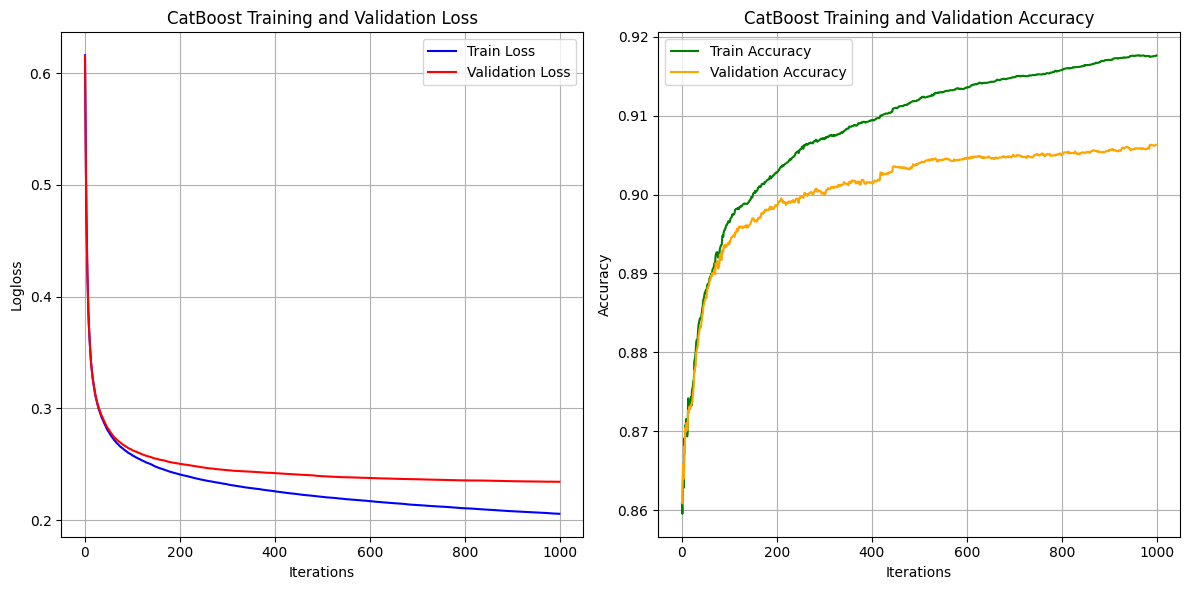

Accuracy: 0.9063210550250114
Confusion Matrix:
[[7030  618]
 [ 824 6921]]
Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.90      0.92      0.91      7648
    Phishing       0.92      0.89      0.91      7745

    accuracy                           0.91     15393
   macro avg       0.91      0.91      0.91     15393
weighted avg       0.91      0.91      0.91     15393



In [ ]:
import os
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import urllib.parse
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import re
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')
df_features = pd.read_csv('/content/drive/My Drive/DoAn/features_with_labels.csv')

X = df_features.drop(columns=['url', 'result'])
y = df_features['result']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Pool objects for training and evaluation
train_pool = Pool(data=X_train, label=y_train)
eval_pool = Pool(data=X_test, label=y_test)

# Create and fit the CatBoost Classifier
clf = CatBoostClassifier(eval_metric="Accuracy", logging_level="Silent")
clf.fit(train_pool, eval_set=eval_pool, plot=False)

# Get evals result (loss and accuracy)
evals_result = clf.get_evals_result()

# Extract loss values
train_loss = evals_result['learn']['Logloss']
val_loss = evals_result['validation']['Logloss']

# Extract accuracy values
train_accuracy = evals_result['learn']['Accuracy']
val_accuracy = evals_result['validation']['Accuracy']

# Print loss and accuracy values for training and validation
print(f"Final Training Loss: {train_loss[-1]}")
print(f"Final Validation Loss: {val_loss[-1]}")
print(f"Final Training Accuracy: {train_accuracy[-1]}")
print(f"Final Validation Accuracy: {val_accuracy[-1]}")

# Plot the loss curves
plt.figure(figsize=(12, 6))

# Plot train and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xlabel('Iterations')
plt.ylabel('Logloss')
plt.title('CatBoost Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot train and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy', color='green')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('CatBoost Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion)

# Save the model
clf.save_model('pretrained_model_html_.bin')

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Phishing']))

In [ ]:
import os
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import urllib.parse
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import re
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')

PATH = '/content/drive/My Drive/DoAn/data_/data'


def count_hyperlinks(html_content):
    try:
        html_content = os.path.join(PATH, html_content)
        # Parse HTML using BeautifulSoup
        soup = BeautifulSoup(html_content, 'html.parser')

        # Count the number of hyperlinks (href, link, and src tags)
        total_hyperlinks = len(soup.find_all(['a', 'link', 'img']))

        # Determine if the website is legitimate or phishing based on the hyperlink count
        return 1 if total_hyperlinks == 0 else 0

    except Exception as e:
        print(f"Error: {e}")
        return 0  # Error occurred


def calculate_internal_link_ratio(html_content, base_domain):
    try:
        # html_content = os.path.join(PATH, html_content)
        # html_content = open(html_content, 'r', encoding='utf-8').read()

        html_content = open(PATH + '/' + html_content, 'r', encoding='utf-8').read()
        soup = BeautifulSoup(html_content, 'html.parser')

        total_links = 0
        internal_links = 0

        for a_tag in soup.find_all('a', href=True):
            total_links += 1
            href = a_tag['href']
            parsed_href = urllib.parse.urlparse(href)

            if not parsed_href.netloc:  # Relative link
                internal_links += 1
            elif parsed_href.netloc == base_domain:  # Internal link
                internal_links += 1

        if total_links == 0:
            return 1  # Avoid division by zero

        internal_link_ratio = internal_links / total_links

        if internal_link_ratio >= 0.5:
            return 0
        else:
            return 1

    except Exception as e:
        print(f"Error: {e}")
        return 0  # Error occurred


def calculate_external_link_ratio(html_content, base_domain):
    try:
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        # html_content = os.path.join(PATH, html_content)
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        html_content = open(PATH + '/' + html_content, 'r', encoding='utf-8').read()
        soup = BeautifulSoup(html_content, 'html.parser')

        total_links = 0
        external_links = 0

        for a_tag in soup.find_all('a', href=True):
            total_links += 1
            href = a_tag['href']
            parsed_href = urllib.parse.urlparse(href)

            if parsed_href.netloc and parsed_href.netloc != base_domain:  # External link
                external_links += 1

        if total_links == 0:
            return 1  # Avoid division by zero

        external_link_ratio = external_links / total_links

        if external_link_ratio < 0.5:
            return 0
        else:
            return 1

    except Exception as e:
        print(f"Error: {e}")
        return 0


def has_external_css(html_content, base_domain):
    try:
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        # html_content = os.path.join(PATH, html_content)
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        html_content = open(PATH + '/' + html_content, 'r', encoding='utf-8').read()
        soup = BeautifulSoup(html_content, 'html.parser')

        for link_tag in soup.find_all('link', rel='stylesheet', href=True):
            href = link_tag['href']
            parsed_href = urllib.parse.urlparse(href)

            if parsed_href.netloc and parsed_href.netloc != base_domain:
                return 1  # External CSS found with a foreign domain

        return 0  # No external CSS with a foreign domain found

    except Exception as e:
        print(f"Error: {e}")
        return 0


def is_suspicious_form_action(html_content, base_domain):
    try:
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        # html_content = os.path.join(PATH, html_content)
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        html_content = open(PATH + '/' + html_content, 'r', encoding='utf-8').read()
        soup = BeautifulSoup(html_content, 'html.parser')

        for form_tag in soup.find_all('form', action=True):
            action = form_tag['action']
            parsed_action = urllib.parse.urlparse(action)

            if parsed_action.netloc and parsed_action.netloc != base_domain:
                return 1  # Suspicious form action with external link or PHP file

            # Additional checks for common suspicious values
            if action.lower() in {'null', '#', 'javascript:void()', 'javascript:void(0)'}:
                return 1  # Suspicious form action with null or JavaScript value

        return 0  # No suspicious form action found

    except Exception as e:
        print(f"Error: {e}")
        return 0

def detect_null_links(html_content):
    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find all anchor tags in the HTML content
    anchors = soup.find_all('a')

    if not anchors:  # If no anchors found, return 0 (no null links)
        return 0

    # Count the number of null links (href contains '#', '#content', 'javascript:void(0)')
    null_links = 0
    total_anchors = len(anchors)

    for anchor in anchors:
        href = anchor.get('href', '')
        if href in ['#', '#content', 'javascript:void(0)']:
            null_links += 1

    # Calculate the ratio of null links
    null_link_ratio = null_links / total_anchors

    # If the ratio of null links is greater than 0.34, return 1 (phishing), else return 0 (legitimate)
    return 1 if null_link_ratio > 0.34 else 0

def is_external_favicon(html_content, base_domain):
    try:
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        # html_content = os.path.join(PATH, html_content)
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        html_content = open(PATH + '/' + html_content, 'r', encoding='utf-8').read()
        soup = BeautifulSoup(html_content, 'html.parser')

        for link_tag in soup.find_all('link', rel='icon', href=True):
            href = link_tag['href']
            parsed_href = urllib.parse.urlparse(href)

            if parsed_href.netloc and parsed_href.netloc != base_domain:
                return 1  # External favicon found with a foreign domain

        return 0  # No external favicon with a foreign domain found

    except Exception as e:
        print(f"Error: {e}")
        return 0


def calculate_common_page_detection_ratio(html_content):
    try:
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        # html_content = os.path.join(PATH, html_content)
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        html_content = open(PATH + '/' + html_content, 'r', encoding='utf-8').read()
        soup = BeautifulSoup(html_content, 'html.parser')

        anchor_links = [a_tag['href'] for a_tag in soup.find_all('a', href=True)]
        if not anchor_links:
            return 0  # No anchor links found

        most_common_link = max(set(anchor_links), key=anchor_links.count)
        common_link_frequency = anchor_links.count(most_common_link)

        common_page_detection_ratio = common_link_frequency / len(anchor_links)
        return common_page_detection_ratio

    except Exception as e:
        print(f"Error: {e}")
        return 0


def calculate_common_page_in_footer_ratio(html_content):
    try:
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        # html_content = os.path.join(PATH, html_content)
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        html_content = open(PATH + '/' + html_content, 'r', encoding='utf-8').read()
        soup = BeautifulSoup(html_content, 'html.parser')

        # Extract anchor links within the footer section
        footer_anchor_links = [a_tag['href'] for footer_tag in soup.find_all('footer') for a_tag in
                               footer_tag.find_all('a', href=True)]

        if not footer_anchor_links:
            return 0  # No anchor links found in the footer section

        most_common_link = max(set(footer_anchor_links), key=footer_anchor_links.count)
        common_link_frequency = footer_anchor_links.count(most_common_link)

        common_page_in_footer_ratio = common_link_frequency / len(footer_anchor_links)
        return common_page_in_footer_ratio

    except Exception as e:
        print(f"Error: {e}")
        return None


def check_sfh(html_content, base_domain):
    try:
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        # html_content = os.path.join(PATH, html_content)
        # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
        html_content = open(PATH + '/' + html_content, 'r', encoding='utf-8').read()
        soup = BeautifulSoup(html_content, 'html.parser')

        for form_tag in soup.find_all('form', action=True):
            sfh = form_tag['action']

            # Check for empty or 'about:blank' SFH
            if sfh.lower() in {'', 'about:blank'}:
                return 0.5  # SFH is empty or 'about:blank'

            # Check if SFH domain is external
            parsed_sfh = urllib.parse.urlparse(sfh)
            if parsed_sfh.netloc and parsed_sfh.netloc != base_domain:
                return 1  # SFH domain is external

        return 0  # Legitimate SFH

    except Exception as e:
        print(f"Error: {e}")
        return 0

def has_www(url):
    pattern = re.compile(r'^www\.')
    match = re.search(pattern, url)
    return 1 if bool(match) else 0


def count_subdomains(url):
    # Check if the URL starts with "http://" or "https://"
    if url.startswith("http://"):
        url = url[7:]
    elif url.startswith("https://"):
        url = url[8:]

    # Split the URL by dots
    parts = url.split('.')

    # Count the number of parts
    part_count = len(parts)

    # Classify the URL based on the specified criteria
    if part_count == 2:
        feature_value = 0.0
    elif part_count == 3:
        feature_value = 0.5
    else:
        feature_value = 1.0

    return feature_value


def check_ip_in_domain(url):
    # Extract the domain from the URL using a regular expression
    domain_match = re.search(r'https?://([^/]+)', url)

    if domain_match:
        domain = domain_match.group(1)

        # Check if the domain is an IP address
        if re.match(r'^\d+\.\d+\.\d+\.\d+$', domain) or re.match(r'^[0-9a-fA-F:]+$', domain):
            feature_value = 1.0
        else:
            feature_value = 0.0
    else:
        feature_value = 0.0

    return feature_value


def check_at_symbol(url):
    # Check if the "@" symbol is present in the URL
    if "@" in url:
        feature_value = 1.0
    else:
        feature_value = 0.0

    return feature_value


def check_url_length(url):
    # Check the length of the URL
    url_length = len(url)

    # Classify the URL based on the specified criteria
    if 75 < url_length < 100:
        feature_value = 0.5
    elif url_length >= 100:
        feature_value = 1.0
    else:
        feature_value = 0.0

    return feature_value


def calculate_url_depth(url):
    # Split the URL path by "/"
    path_segments = url.split("/")[3:]  # Exclude the protocol (http/https) and domain

    # Calculate the depth based on the number of subpages
    url_depth = len(path_segments)

    # Return the numerical feature value
    return url_depth


def check_double_slash(url):
    # Find the last occurrence of "//" in the URL
    last_double_slash = url.rfind("//")

    # Classify the URL based on the specified criteria
    if last_double_slash > 7:
        feature_value = 1.0
    else:
        feature_value = 0.0

    return feature_value


def check_http_in_domain(url):
    # Extract the domain from the URL
    domain_start = url.find('//') + 2
    domain_end = url.find('/', domain_start)

    if domain_end == -1:
        domain_end = None

    domain = url[domain_start:domain_end]

    # Check if "http" or "https" is present in the domain
    if "http" in domain:
        feature_value = 1.0
    else:
        feature_value = 0.0

    return feature_value


def check_https_protocol(url):
    # Check if the URL has the "https" protocol
    if url.startswith('https://'):
        feature_value = 0.0
    else:
        feature_value = 1.0

    return feature_value


def check_url_shortening(url):
    # List of common URL shortening services
    shortening_services = ['bit.ly', 'goo.gl', 'tinyurl.com', 'ow.ly', 't.co']

    # Check if the URL contains any of the shortening service domains
    if any(service in url for service in shortening_services):
        feature_value = 1.0
    else:
        feature_value = 0.0

    return feature_value


def check_dash_in_domain(url):
    # Extract the domain from the URL
    domain_start = url.find('//') + 2
    domain_end = url.find('/', domain_start)

    if domain_end == -1:
        domain_end = None

    domain = url[domain_start:domain_end]

    # Check if "-" is present in the domain
    if '-' in domain:
        feature_value = 1.0
    else:
        feature_value = 0.0

    return feature_value


def check_sensitive_words(url):
    # List of sensitive words/phishing terms
    phishing_terms = ['login', 'update', 'validate', 'activate', 'secure', 'account', 'verification', 'password',
                      'confirm', 'verification', 'signin', 'recover', 'auth', 'identity', 'info', 'alert', 'warning',
                      'urgent']

    # Convert the URL to lowercase for case-insensitive matching
    url_lower = url.lower()

    # Check if the URL contains any of the phishing terms
    if any(term in url_lower for term in phishing_terms):
        feature_value = 1.0
    else:
        feature_value = 0.0

    return feature_value


def check_trendy_brand_name(url):
    # List of trendy brand names that phishers often target
    trendy_brands = ['apple', 'google', 'microsoft', 'amazon', 'facebook', 'paypal', 'netflix', 'instagram', 'twitter',
                     'linkedin', 'ebay', 'yahoo', 'dropbox', 'adobe', 'linkedin', 'outlook', 'snapchat', 'uber',
                     'whatsapp']

    # Convert the URL to lowercase for case-insensitive matching
    url_lower = url.lower()

    # Check if the URL contains any of the trendy brand names
    if any(brand in url_lower for brand in trendy_brands):
        feature_value = 1.0
    else:
        feature_value = 0.0

    return feature_value


def check_uppercase_letters(url):
    # Check if the URL contains any uppercase letters
    if any(char.isupper() for char in url):
        feature_value = 1.0
    else:
        feature_value = 0.0

    return feature_value


def count_dots(url):
    # Count the number of dots in the URL
    dot_count = url.count('.')

    # Check if the number of dots is more than 2
    if dot_count > 2:
        feature_value = 1.0
    else:
        feature_value = 0.0

    return feature_value


df = pd.read_csv("/content/drive/My Drive/DoAn/test.csv", on_bad_lines='skip', encoding="latin-1")


df['UF1'] = df['website'].apply(lambda x: count_hyperlinks(x))

df['UF1'] = df['website'].apply(lambda x: count_hyperlinks(x))
df['UF2'] = df.apply(
    lambda row: calculate_internal_link_ratio(row['website'], urllib.parse.urlparse(row['url']).netloc), axis=1)

df['UF3'] = df.apply(
    lambda row: calculate_external_link_ratio(row['website'], urllib.parse.urlparse(row['url']).netloc), axis=1)
df['UF4'] = df.apply(lambda row: has_external_css(row['website'], urllib.parse.urlparse(row['url']).netloc), axis=1)
df['UF5'] = df.apply(lambda row: is_suspicious_form_action(row['website'], urllib.parse.urlparse(row['url']).netloc),
                     axis=1)
df['UF6'] = df.apply(lambda row: detect_null_links(row['website']), axis=1)
df['UF7'] = df.apply(lambda row: is_external_favicon(row['website'], urllib.parse.urlparse(row['url']).netloc), axis=1)
df['UF8'] = df.apply(lambda row: calculate_common_page_detection_ratio(row['website']), axis=1)
df['UF9'] = df.apply(lambda row: calculate_common_page_in_footer_ratio(row['website']), axis=1)
df['UF10'] = df.apply(lambda row: check_sfh(row['website'], urllib.parse.urlparse(row['url']).netloc), axis=1)
df['UF11'] = df.apply(lambda row: has_www(row['url']), axis=1)
df['UF12'] = df.apply(lambda row: count_subdomains(row['url']), axis=1)
df['UF13'] = df.apply(lambda row: check_ip_in_domain(row['url']), axis=1)
df['UF14'] = df.apply(lambda row: check_at_symbol(row['url']), axis=1)
df['UF15'] = df.apply(lambda row: check_url_length(row['url']), axis=1)
df['UF16'] = df.apply(lambda row: calculate_url_depth(row['url']), axis=1)
df['UF17'] = df.apply(lambda row: check_double_slash(row['url']), axis=1)
df['UF18'] = df.apply(lambda row: check_http_in_domain(row['url']), axis=1)
df['UF19'] = df.apply(lambda row: check_https_protocol(row['url']), axis=1)
df['UF20'] = df.apply(lambda row: check_url_shortening(row['url']), axis=1)
df['UF21'] = df.apply(lambda row: check_dash_in_domain(row['url']), axis=1)
df['UF22'] = df.apply(lambda row: check_sensitive_words(row['url']), axis=1)
df['UF23'] = df.apply(lambda row: check_trendy_brand_name(row['url']), axis=1)
df['UF24'] = df.apply(lambda row: check_uppercase_letters(row['url']), axis=1)
df['UF25'] = df.apply(lambda row: count_dots(row['url']), axis=1)

feature_columns_ = ['url', 'UF1', 'UF2', 'UF3','UF4', 'UF5', 'UF6', 'UF7','UF8', 'UF9', 'UF10', 'UF11',
                    'UF12', 'UF13', 'UF14', 'UF15','UF16', 'UF17', 'UF18', 'UF19' ,'UF20','UF21', 'UF22', 'UF23', 'UF24','UF25', 'result']
df[feature_columns_].to_csv('/content/drive/My Drive/DoAn/features_with_labels_test.csv', index=False)





Streaming output truncated to the last 5000 lines.
Error: [Errno 2] No such file or directory: '/content/drive/My Drive/DoAn/data_/data/1635704622937875.html'
Error: [Errno 2] No such file or directory: '/content/drive/My Drive/DoAn/data_/data/1626706276635338.html'
Error: [Errno 2] No such file or directory: '/content/drive/My Drive/DoAn/data_/data/1626970430157382.html'
Error: [Errno 2] No such file or directory: '/content/drive/My Drive/DoAn/data_/data/1635711177618697.html'
Error: [Errno 2] No such file or directory: '/content/drive/My Drive/DoAn/data_/data/1635705700807941.html'
Error: [Errno 2] No such file or directory: '/content/drive/My Drive/DoAn/data_/data/1626122057331788.html'
Error: [Errno 2] No such file or directory: '/content/drive/My Drive/DoAn/data_/data/1635704549988464.html'
Error: [Errno 2] No such file or directory: '/content/drive/My Drive/DoAn/data_/data/1635708942221741.html'
Error: [Errno 2] No such file or directory: '/content/drive/My Drive/DoAn/data_/data/

Accuracy on remaining data: 0.9032748538011696
Confusion Matrix on remaining data:
[[3930  345]
 [ 482 3793]]
Classification Report on remaining data:
              precision    recall  f1-score   support

  Legitimate       0.89      0.92      0.90      4275
    Phishing       0.92      0.89      0.90      4275

    accuracy                           0.90      8550
   macro avg       0.90      0.90      0.90      8550
weighted avg       0.90      0.90      0.90      8550



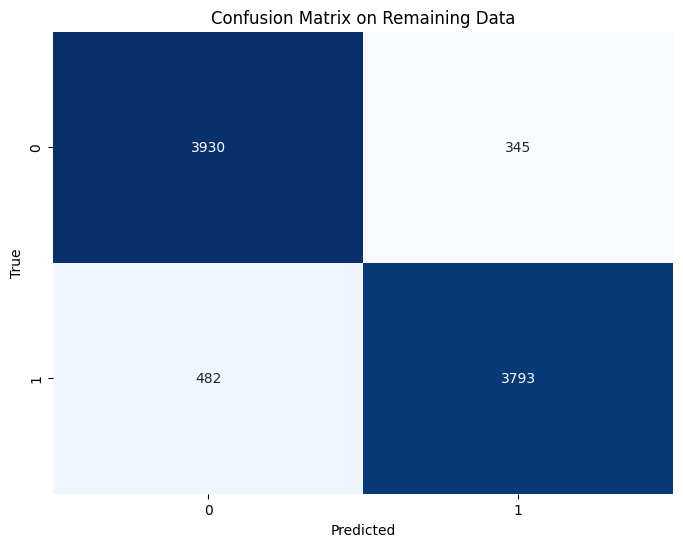

In [ ]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.parse
import re

# Đọc dữ liệu từ file remaining_data
# df_remaining = pd.read_csv("/content/drive/My Drive/DoAn/test.csv", on_bad_lines='skip', encoding="latin-1")
# # Áp dụng các hàm vào dữ liệu
# df_remaining['UF1'] = df_remaining['website'].apply(lambda x: count_hyperlinks(x))
# df_remaining['UF2'] = df_remaining.apply(lambda row: calculate_internal_link_ratio(row['website'], urllib.parse.urlparse(row['url']).netloc), axis=1)
# df_remaining['UF3'] = df_remaining.apply(lambda row: calculate_external_link_ratio(row['website'], urllib.parse.urlparse(row['url']).netloc), axis=1)
# df_remaining['UF4'] = df_remaining.apply(lambda row: has_external_css(row['website'], urllib.parse.urlparse(row['url']).netloc), axis=1)
# df_remaining['UF5'] = df_remaining.apply(lambda row: is_suspicious_form_action(row['website'], urllib.parse.urlparse(row['url']).netloc), axis=1)
# df_remaining['UF6'] = df_remaining.apply(lambda row: detect_null_links(row['website']), axis=1)
# df_remaining['UF7'] = df_remaining.apply(lambda row: is_external_favicon(row['website'], urllib.parse.urlparse(row['url']).netloc), axis=1)
# df_remaining['UF8'] = df_remaining.apply(lambda row: calculate_common_page_detection_ratio(row['website']), axis=1)
# df_remaining['UF9'] = df_remaining.apply(lambda row: calculate_common_page_in_footer_ratio(row['website']), axis=1)
# df_remaining['UF10'] = df_remaining.apply(lambda row: check_sfh(row['website'], urllib.parse.urlparse(row['url']).netloc), axis=1)
# df_remaining['UF11'] = df_remaining.apply(lambda row: has_www(row['url']), axis=1)
# df_remaining['UF12'] = df_remaining.apply(lambda row: count_subdomains(row['url']), axis=1)
# df_remaining['UF13'] = df_remaining.apply(lambda row: check_ip_in_domain(row['url']), axis=1)
# df_remaining['UF14'] = df_remaining.apply(lambda row: check_at_symbol(row['url']), axis=1)
# df_remaining['UF15'] = df_remaining.apply(lambda row: check_url_length(row['url']), axis=1)
# df_remaining['UF16'] = df_remaining.apply(lambda row: calculate_url_depth(row['url']), axis=1)
# df_remaining['UF17'] = df_remaining.apply(lambda row: check_double_slash(row['url']), axis=1)
# df_remaining['UF18'] = df_remaining.apply(lambda row: check_http_in_domain(row['url']), axis=1)
# df_remaining['UF19'] = df_remaining.apply(lambda row: check_https_protocol(row['url']), axis=1)
# df_remaining['UF20'] = df_remaining.apply(lambda row: check_url_shortening(row['url']), axis=1)
# df_remaining['UF21'] = df_remaining.apply(lambda row: check_dash_in_domain(row['url']), axis=1)
# df_remaining['UF22'] = df_remaining.apply(lambda row: check_sensitive_words(row['url']), axis=1)
# df_remaining['UF23'] = df_remaining.apply(lambda row: check_trendy_brand_name(row['url']), axis=1)
# df_remaining['UF24'] = df_remaining.apply(lambda row: check_uppercase_letters(row['url']), axis=1)
# df_remaining['UF25'] = df_remaining.apply(lambda row: count_dots(row['url']), axis=1)
df_remaining = pd.read_csv("/content/drive/My Drive/DoAn/features_with_labels_test.csv")
df_remaining = df_remaining.fillna(0)
X_remaining = df_remaining.drop(columns=[ 'url', 'result'])
y_remaining = df_remaining['result']

# Đọc mô hình đã lưu
clf = CatBoostClassifier()
clf.load_model('pretrained_model_html_.bin')

# Dự đoán trên dữ liệu mới
y_pred_remaining = clf.predict(X_remaining)

# Tính toán độ chính xác
accuracy_remaining = accuracy_score(y_remaining, y_pred_remaining)
print("Accuracy on remaining data:", accuracy_remaining)

# Tính toán ma trận nhầm lẫn
confusion_remaining = confusion_matrix(y_remaining, y_pred_remaining)
print("Confusion Matrix on remaining data:")
print(confusion_remaining)

# Hiển thị báo cáo phân loại
print("Classification Report on remaining data:")
print(classification_report(y_remaining, y_pred_remaining, target_names=['Legitimate', 'Phishing']))

# Hiển thị ma trận nhầm lẫn bằng Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_remaining, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Remaining Data')
plt.show()

Accuracy: 0.9056064444877542
Confusion Matrix:
[[7015  633]
 [ 820 6925]]
Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.90      0.92      0.91      7648
    Phishing       0.92      0.89      0.91      7745

    accuracy                           0.91     15393
   macro avg       0.91      0.91      0.91     15393
weighted avg       0.91      0.91      0.91     15393



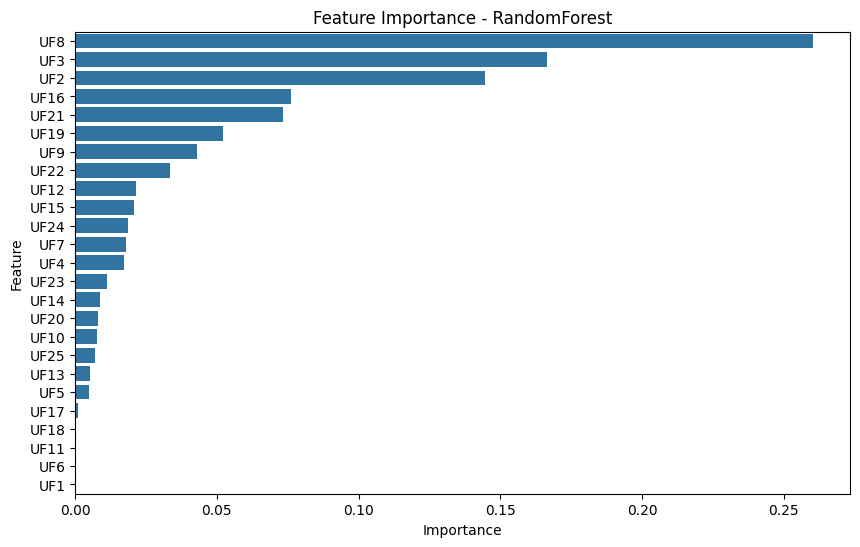

In [ ]:
import os
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import urllib.parse
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import re
from sklearn.impute import SimpleImputer
warnings.filterwarnings('ignore')

# PATH = '/content/drive/My Drive/DoAn/data_/data'


# def count_hyperlinks(html_content):
#     try:
#         html_content = os.path.join(PATH, html_content)
#         # Parse HTML using BeautifulSoup
#         soup = BeautifulSoup(html_content, 'html.parser')

#         # Count the number of hyperlinks (href, link, and src tags)
#         total_hyperlinks = len(soup.find_all(['a', 'link', 'img']))

#         # Determine if the website is legitimate or phishing based on the hyperlink count
#         return 1 if total_hyperlinks == 0 else 0

#     except Exception as e:
#         print(f"Error: {e}")
#         return 0  # Error occurred


# def calculate_internal_link_ratio(html_content, base_domain):
#     try:
#         # html_content = os.path.join(PATH, html_content)
#         # html_content = open(html_content, 'r', encoding='utf-8').read()

#         html_content = open(PATH + '/' + html_content, 'r', encoding='utf-8').read()
#         soup = BeautifulSoup(html_content, 'html.parser')

#         total_links = 0
#         internal_links = 0

#         for a_tag in soup.find_all('a', href=True):
#             total_links += 1
#             href = a_tag['href']
#             parsed_href = urllib.parse.urlparse(href)

#             if not parsed_href.netloc:  # Relative link
#                 internal_links += 1
#             elif parsed_href.netloc == base_domain:  # Internal link
#                 internal_links += 1

#         if total_links == 0:
#             return 1  # Avoid division by zero

#         internal_link_ratio = internal_links / total_links

#         if internal_link_ratio >= 0.5:
#             return 0
#         else:
#             return 1

#     except Exception as e:
#         print(f"Error: {e}")
#         return 0  # Error occurred


# def calculate_external_link_ratio(html_content, base_domain):
#     try:
#         # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
#         # html_content = os.path.join(PATH, html_content)
#         # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
#         html_content = open(PATH + '/' + html_content, 'r', encoding='utf-8').read()
#         soup = BeautifulSoup(html_content, 'html.parser')

#         total_links = 0
#         external_links = 0

#         for a_tag in soup.find_all('a', href=True):
#             total_links += 1
#             href = a_tag['href']
#             parsed_href = urllib.parse.urlparse(href)

#             if parsed_href.netloc and parsed_href.netloc != base_domain:  # External link
#                 external_links += 1

#         if total_links == 0:
#             return 1  # Avoid division by zero

#         external_link_ratio = external_links / total_links

#         if external_link_ratio < 0.5:
#             return 0
#         else:
#             return 1

#     except Exception as e:
#         print(f"Error: {e}")
#         return 0


# def has_external_css(html_content, base_domain):
#     try:
#         # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
#         # html_content = os.path.join(PATH, html_content)
#         # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
#         html_content = open(PATH + '/' + html_content, 'r', encoding='utf-8').read()
#         soup = BeautifulSoup(html_content, 'html.parser')

#         for link_tag in soup.find_all('link', rel='stylesheet', href=True):
#             href = link_tag['href']
#             parsed_href = urllib.parse.urlparse(href)

#             if parsed_href.netloc and parsed_href.netloc != base_domain:
#                 return 1  # External CSS found with a foreign domain

#         return 0  # No external CSS with a foreign domain found

#     except Exception as e:
#         print(f"Error: {e}")
#         return 0


# def is_suspicious_form_action(html_content, base_domain):
#     try:
#         # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
#         # html_content = os.path.join(PATH, html_content)
#         # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
#         html_content = open(PATH + '/' + html_content, 'r', encoding='utf-8').read()
#         soup = BeautifulSoup(html_content, 'html.parser')

#         for form_tag in soup.find_all('form', action=True):
#             action = form_tag['action']
#             parsed_action = urllib.parse.urlparse(action)

#             if parsed_action.netloc and parsed_action.netloc != base_domain:
#                 return 1  # Suspicious form action with external link or PHP file

#             # Additional checks for common suspicious values
#             if action.lower() in {'null', '#', 'javascript:void()', 'javascript:void(0)'}:
#                 return 1  # Suspicious form action with null or JavaScript value

#         return 0  # No suspicious form action found

#     except Exception as e:
#         print(f"Error: {e}")
#         return 0


# def is_external_favicon(html_content, base_domain):
#     try:
#         # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
#         # html_content = os.path.join(PATH, html_content)
#         # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
#         html_content = open(PATH + '/' + html_content, 'r', encoding='utf-8').read()
#         soup = BeautifulSoup(html_content, 'html.parser')

#         for link_tag in soup.find_all('link', rel='icon', href=True):
#             href = link_tag['href']
#             parsed_href = urllib.parse.urlparse(href)

#             if parsed_href.netloc and parsed_href.netloc != base_domain:
#                 return 1  # External favicon found with a foreign domain

#         return 0  # No external favicon with a foreign domain found

#     except Exception as e:
#         print(f"Error: {e}")
#         return 0


# def calculate_common_page_detection_ratio(html_content):
#     try:
#         # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
#         # html_content = os.path.join(PATH, html_content)
#         # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
#         html_content = open(PATH + '/' + html_content, 'r', encoding='utf-8').read()
#         soup = BeautifulSoup(html_content, 'html.parser')

#         anchor_links = [a_tag['href'] for a_tag in soup.find_all('a', href=True)]
#         if not anchor_links:
#             return 0  # No anchor links found

#         most_common_link = max(set(anchor_links), key=anchor_links.count)
#         common_link_frequency = anchor_links.count(most_common_link)

#         common_page_detection_ratio = common_link_frequency / len(anchor_links)
#         return common_page_detection_ratio

#     except Exception as e:
#         print(f"Error: {e}")
#         return 0


# def calculate_common_page_in_footer_ratio(html_content):
#     try:
#         # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
#         # html_content = os.path.join(PATH, html_content)
#         # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
#         html_content = open(PATH + '/' + html_content, 'r', encoding='utf-8').read()
#         soup = BeautifulSoup(html_content, 'html.parser')

#         # Extract anchor links within the footer section
#         footer_anchor_links = [a_tag['href'] for footer_tag in soup.find_all('footer') for a_tag in
#                                footer_tag.find_all('a', href=True)]

#         if not footer_anchor_links:
#             return 0  # No anchor links found in the footer section

#         most_common_link = max(set(footer_anchor_links), key=footer_anchor_links.count)
#         common_link_frequency = footer_anchor_links.count(most_common_link)

#         common_page_in_footer_ratio = common_link_frequency / len(footer_anchor_links)
#         return common_page_in_footer_ratio

#     except Exception as e:
#         print(f"Error: {e}")
#         return None


# def check_sfh(html_content, base_domain):
#     try:
#         # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
#         # html_content = os.path.join(PATH, html_content)
#         # html_content = open(os.path.join(PATH, html_content), 'r', encoding='utf-8').read()
#         html_content = open(PATH + '/' + html_content, 'r', encoding='utf-8').read()
#         soup = BeautifulSoup(html_content, 'html.parser')

#         for form_tag in soup.find_all('form', action=True):
#             sfh = form_tag['action']

#             # Check for empty or 'about:blank' SFH
#             if sfh.lower() in {'', 'about:blank'}:
#                 return 0.5  # SFH is empty or 'about:blank'

#             # Check if SFH domain is external
#             parsed_sfh = urllib.parse.urlparse(sfh)
#             if parsed_sfh.netloc and parsed_sfh.netloc != base_domain:
#                 return 1  # SFH domain is external

#         return 0  # Legitimate SFH

#     except Exception as e:
#         print(f"Error: {e}")
#         return 0

# def has_www(url):
#     pattern = re.compile(r'^www\.')
#     match = re.search(pattern, url)
#     return 1 if bool(match) else 0


# def count_subdomains(url):
#     # Check if the URL starts with "http://" or "https://"
#     if url.startswith("http://"):
#         url = url[7:]
#     elif url.startswith("https://"):
#         url = url[8:]

#     # Split the URL by dots
#     parts = url.split('.')

#     # Count the number of parts
#     part_count = len(parts)

#     # Classify the URL based on the specified criteria
#     if part_count == 2:
#         feature_value = 0.0
#     elif part_count == 3:
#         feature_value = 0.5
#     else:
#         feature_value = 1.0

#     return feature_value


# def check_ip_in_domain(url):
#     # Extract the domain from the URL using a regular expression
#     domain_match = re.search(r'https?://([^/]+)', url)

#     if domain_match:
#         domain = domain_match.group(1)

#         # Check if the domain is an IP address
#         if re.match(r'^\d+\.\d+\.\d+\.\d+$', domain) or re.match(r'^[0-9a-fA-F:]+$', domain):
#             feature_value = 1.0
#         else:
#             feature_value = 0.0
#     else:
#         feature_value = 0.0

#     return feature_value


# def check_at_symbol(url):
#     # Check if the "@" symbol is present in the URL
#     if "@" in url:
#         feature_value = 1.0
#     else:
#         feature_value = 0.0

#     return feature_value


# def check_url_length(url):
#     # Check the length of the URL
#     url_length = len(url)

#     # Classify the URL based on the specified criteria
#     if 75 < url_length < 100:
#         feature_value = 0.5
#     elif url_length >= 100:
#         feature_value = 1.0
#     else:
#         feature_value = 0.0

#     return feature_value


# def calculate_url_depth(url):
#     # Split the URL path by "/"
#     path_segments = url.split("/")[3:]  # Exclude the protocol (http/https) and domain

#     # Calculate the depth based on the number of subpages
#     url_depth = len(path_segments)

#     # Return the numerical feature value
#     return url_depth


# def check_double_slash(url):
#     # Find the last occurrence of "//" in the URL
#     last_double_slash = url.rfind("//")

#     # Classify the URL based on the specified criteria
#     if last_double_slash > 7:
#         feature_value = 1.0
#     else:
#         feature_value = 0.0

#     return feature_value


# def check_http_in_domain(url):
#     # Extract the domain from the URL
#     domain_start = url.find('//') + 2
#     domain_end = url.find('/', domain_start)

#     if domain_end == -1:
#         domain_end = None

#     domain = url[domain_start:domain_end]

#     # Check if "http" or "https" is present in the domain
#     if "http" in domain:
#         feature_value = 1.0
#     else:
#         feature_value = 0.0

#     return feature_value


# def check_https_protocol(url):
#     # Check if the URL has the "https" protocol
#     if url.startswith('https://'):
#         feature_value = 0.0
#     else:
#         feature_value = 1.0

#     return feature_value


# def check_url_shortening(url):
#     # List of common URL shortening services
#     shortening_services = ['bit.ly', 'goo.gl', 'tinyurl.com', 'ow.ly', 't.co']

#     # Check if the URL contains any of the shortening service domains
#     if any(service in url for service in shortening_services):
#         feature_value = 1.0
#     else:
#         feature_value = 0.0

#     return feature_value


# def check_dash_in_domain(url):
#     # Extract the domain from the URL
#     domain_start = url.find('//') + 2
#     domain_end = url.find('/', domain_start)

#     if domain_end == -1:
#         domain_end = None

#     domain = url[domain_start:domain_end]

#     # Check if "-" is present in the domain
#     if '-' in domain:
#         feature_value = 1.0
#     else:
#         feature_value = 0.0

#     return feature_value


# def check_sensitive_words(url):
#     # List of sensitive words/phishing terms
#     phishing_terms = ['login', 'update', 'validate', 'activate', 'secure', 'account', 'verification', 'password',
#                       'confirm', 'verification', 'signin', 'recover', 'auth', 'identity', 'info', 'alert', 'warning',
#                       'urgent']

#     # Convert the URL to lowercase for case-insensitive matching
#     url_lower = url.lower()

#     # Check if the URL contains any of the phishing terms
#     if any(term in url_lower for term in phishing_terms):
#         feature_value = 1.0
#     else:
#         feature_value = 0.0

#     return feature_value


# def check_trendy_brand_name(url):
#     # List of trendy brand names that phishers often target
#     trendy_brands = ['apple', 'google', 'microsoft', 'amazon', 'facebook', 'paypal', 'netflix', 'instagram', 'twitter',
#                      'linkedin', 'ebay', 'yahoo', 'dropbox', 'adobe', 'linkedin', 'outlook', 'snapchat', 'uber',
#                      'whatsapp']

#     # Convert the URL to lowercase for case-insensitive matching
#     url_lower = url.lower()

#     # Check if the URL contains any of the trendy brand names
#     if any(brand in url_lower for brand in trendy_brands):
#         feature_value = 1.0
#     else:
#         feature_value = 0.0

#     return feature_value


# def check_uppercase_letters(url):
#     # Check if the URL contains any uppercase letters
#     if any(char.isupper() for char in url):
#         feature_value = 1.0
#     else:
#         feature_value = 0.0

#     return feature_value


# def count_dots(url):
#     # Count the number of dots in the URL
#     dot_count = url.count('.')

#     # Check if the number of dots is more than 2
#     if dot_count > 2:
#         feature_value = 1.0
#     else:
#         feature_value = 0.0

#     return feature_value


# df = pd.read_csv("/content/drive/My Drive/DoAn/data.csv", on_bad_lines='skip', encoding="latin-1")


# df['UF1'] = df['website'].apply(lambda x: count_hyperlinks(x))

# df['UF1'] = df['website'].apply(lambda x: count_hyperlinks(x))
# df['UF2'] = df.apply(
#     lambda row: calculate_internal_link_ratio(row['website'], urllib.parse.urlparse(row['url']).netloc), axis=1)

# df['UF3'] = df.apply(
#     lambda row: calculate_external_link_ratio(row['website'], urllib.parse.urlparse(row['url']).netloc), axis=1)
# df['UF4'] = df.apply(lambda row: has_external_css(row['website'], urllib.parse.urlparse(row['url']).netloc), axis=1)
# df['UF5'] = df.apply(lambda row: is_suspicious_form_action(row['website'], urllib.parse.urlparse(row['url']).netloc),
#                      axis=1)
# df['UF6'] = df.apply(lambda row: is_external_favicon(row['website'], urllib.parse.urlparse(row['url']).netloc), axis=1)
# df['UF7'] = df.apply(lambda row: calculate_common_page_detection_ratio(row['website']), axis=1)
# df['UF8'] = df.apply(lambda row: calculate_common_page_in_footer_ratio(row['website']), axis=1)
# df['UF9'] = df.apply(lambda row: check_sfh(row['website'], urllib.parse.urlparse(row['url']).netloc), axis=1)
# df['UF10'] = df.apply(lambda row: has_www(row['url']), axis=1)
# df['UF11'] = df.apply(lambda row: count_subdomains(row['url']), axis=1)
# df['UF12'] = df.apply(lambda row: check_ip_in_domain(row['url']), axis=1)
# df['UF13'] = df.apply(lambda row: check_at_symbol(row['url']), axis=1)
# df['UF14'] = df.apply(lambda row: check_url_length(row['url']), axis=1)
# df['UF15'] = df.apply(lambda row: calculate_url_depth(row['url']), axis=1)
# df['UF16'] = df.apply(lambda row: check_double_slash(row['url']), axis=1)
# df['UF17'] = df.apply(lambda row: check_http_in_domain(row['url']), axis=1)
# df['UF18'] = df.apply(lambda row: check_https_protocol(row['url']), axis=1)
# df['UF19'] = df.apply(lambda row: check_url_shortening(row['url']), axis=1)
# df['UF20'] = df.apply(lambda row: check_dash_in_domain(row['url']), axis=1)
# df['UF21'] = df.apply(lambda row: check_sensitive_words(row['url']), axis=1)
# df['UF22'] = df.apply(lambda row: check_trendy_brand_name(row['url']), axis=1)
# df['UF23'] = df.apply(lambda row: check_uppercase_letters(row['url']), axis=1)
# df['UF24'] = df.apply(lambda row: count_dots(row['url']), axis=1)

# df = df.fillna(0)
# X = df.drop(columns=['rec_id', 'url', 'result', 'website', 'created_date'])
# y = df['result']

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
df_features = pd.read_csv('/content/drive/My Drive/DoAn/features_with_labels.csv')

# Thay thế tất cả các giá trị NaN bằng 0
df_features = df_features.fillna(0)

# Tách dữ liệu thành các biến đặc trưng (features) và nhãn (target)
X = df_features.drop(columns=['url', 'result'])
y = df_features['result']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Định nghĩa mô hình RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Huấn luyện mô hình
rf_clf.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = rf_clf.predict(X_test)

# Tính toán độ chính xác và ma trận nhầm lẫn
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)

# Báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Phishing']))

# Đồ thị quan trọng của các đặc trưng
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf_clf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance - RandomForest')
plt.show()

Accuracy: 0.9267109564483813
Confusion Matrix:
[[2681  425]
 [ 270 6107]]
Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.91      0.86      0.89      3106
    Phishing       0.93      0.96      0.95      6377

    accuracy                           0.93      9483
   macro avg       0.92      0.91      0.92      9483
weighted avg       0.93      0.93      0.93      9483



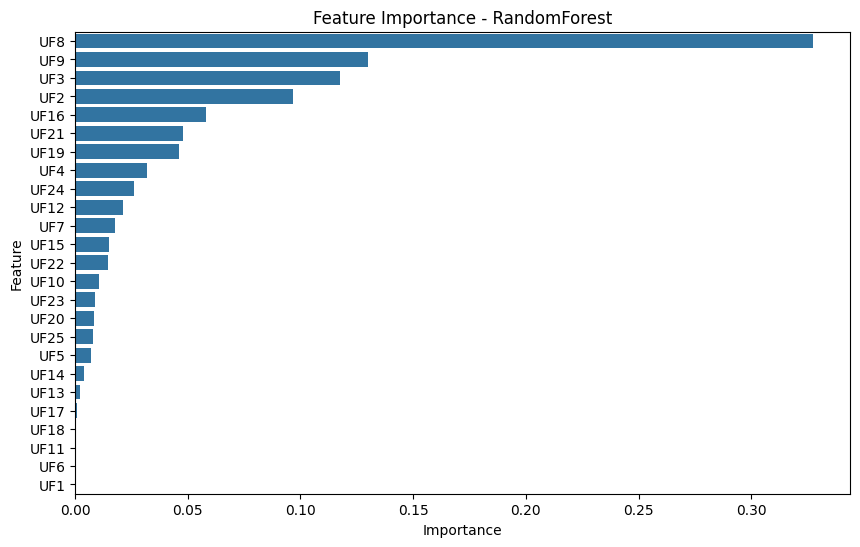

In [ ]:
import os
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import urllib.parse
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import re
from sklearn.impute import SimpleImputer
warnings.filterwarnings('ignore')
df_features = pd.read_csv('/content/drive/My Drive/DoAn/features_with_labels.csv')

# Remove rows with NaN values
df_features = df_features.dropna()

X = df_features.drop(columns=['url', 'result'])
y = df_features['result']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define RandomForest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred = rf_clf.predict(X_test)

# Accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Phishing']))

# Feature importance plot
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf_clf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance - RandomForest')
plt.show()